### Pre-mining data processing

Remove unnecessary attributes, rename attributes for ease of referencing

In [12]:
import pandas as pd
import math, random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Specify the input CSV file and row number to split at
input_file = 'merged_datasets.csv'
# Function to separate CSV based on row number

# Read the input CSV file
df = pd.read_csv(input_file, header="infer")

# Split the DataFrame based on the row number
df = df.drop(columns=["HUMAN PLAYER POSITION (X) metres","HUMAN PLAYER POSITION (Y) metres","INITITAL VELOCITY OF SHUTTELCOCK(m/s)","INITIAL SHUTTELCOCK FIRING ANGLE (DEGREE)","SHUTTELCOCK SLANT ANGLE TO SIDELINE(DEGREE)","OUT_OF_COURT_SHOTS"])
df = df.rename(columns={"SHUTTLECOCK POSITIION IN AIR(X ) metres":"X","SHUTTLECOCK POSITIION IN AIR(Y) metres":"Y","SHUTTLECOCK POSITIION IN AIR(Z) metres":"Z"})

print(df.shape)
df

(91348, 4)


,SHOT_ID,X,Y,Z
0,1,4.075543,1.000000,1.662912
1,1,4.152007,1.000000,1.724866
2,1,4.228906,1.000000,1.788139
3,1,4.302100,1.000000,1.845245
4,1,4.376877,1.000000,1.904128
...,...,...,...,...
91343,658,8.061748,8.840603,6.084177
91344,658,8.088022,8.871915,6.044289
91345,658,8.111243,8.899588,6.001045
91346,658,8.138342,8.931884,5.952024


Create training and testing set

In [13]:
numShots = df["SHOT_ID"].max()
print(numShots)
trainsetSize = int(numShots*0.7)
print(trainsetSize)
testsetSize = numShots-trainsetSize
traindata = df.loc[df["SHOT_ID"]<= trainsetSize]
testdata = df.loc[df["SHOT_ID"] > trainsetSize]
print(traindata.head())
print(testdata.head())

658
460
   SHOT_ID         X    Y         Z
0        1  4.075543  1.0  1.662912
1        1  4.152007  1.0  1.724866
2        1  4.228906  1.0  1.788139
3        1  4.302100  1.0  1.845245
4        1  4.376877  1.0  1.904128
       SHOT_ID         X         Y         Z
61196      461  4.050120  1.005268  2.685985
61197      461  4.099803  1.010490  2.770552
61198      461  4.147361  1.015488  2.853052
61199      461  4.197503  1.020758  2.934503
61200      461  4.245438  1.025797  3.013947


Scale data to normalise

In [14]:
scale = MinMaxScaler()
traindata[["X","Y","Z"]] = scale.fit_transform(traindata[["X","Y","Z"]])
testdata[["X","Y","Z"]] = scale.fit_transform(testdata[["X","Y","Z"]])
print(traindata.head())
print(testdata.head())

   SHOT_ID         X    Y         Z
0        1  0.005270  0.0  0.247642
1        1  0.019367  0.0  0.257424
2        1  0.033543  0.0  0.267413
3        1  0.047036  0.0  0.276429
4        1  0.060821  0.0  0.285726
       SHOT_ID         X         Y         Z
61196      461  0.000605  0.000000  0.403795
61197      461  0.010597  0.000654  0.417263
61198      461  0.020161  0.001281  0.430403
61199      461  0.030245  0.001941  0.443376
61200      461  0.039886  0.002573  0.456029


C:\Users\Esther\AppData\Local\Temp\ipykernel_39188\3751249483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traindata[["X","Y","Z"]] = scale.fit_transform(traindata[["X","Y","Z"]])
C:\Users\Esther\AppData\Local\Temp\ipykernel_39188\3751249483.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdata[["X","Y","Z"]] = scale.fit_transform(testdata[["X","Y","Z"]])


prepare_data function to create attribute set (X,Y,Z) and class labels

In [30]:
# Individual data points in X, Y
def prepare_data(data, sequence_length):
    X = []
    Y = []
    for shot_id in data['SHOT_ID'].unique(): # for each shot id
        X.append(data.loc[data['SHOT_ID'] == shot_id][['X', 'Y', 'Z']].values[0:sequence_length]) # get xyz
        Y.append(data.loc[data['SHOT_ID'] == shot_id][['X', 'Y', 'Z']].values[1:sequence_length+1])
    X = np.array(X)
    X = X.reshape(-1, 3)
    Y = np.array(Y)
    Y = Y.reshape(-1, 3)
    print(X.shape, Y.shape)
    return X, Y

# Delta between consecutive data points in X, Y
def prepare_data_deltas(data, sequence_length):
    X = []
    Y = []
    for shot_id in data['SHOT_ID'].unique(): # for each shot id
        shotdata = (data.loc[data['SHOT_ID'] == shot_id][['X', 'Y', 'Z']].values) # get xyz
        X1 = shotdata[:sequence_length]
        X2 = shotdata[1:sequence_length+1] 
        X.append(X2 - X1)
        Y1 = shotdata[1:sequence_length+1]
        Y2 = shotdata[2:sequence_length+2]
        Y.append(Y2 - Y1)
    X = np.array(X, dtype=object)
    X = np.concatenate(X)
    X = X.reshape(-1, 3)
    Y = np.array(Y, dtype=object)
    Y = np.concatenate(Y)
    Y = Y.reshape(-1, 3)
    # final shape should be n rows of 3
    print(X.shape, Y.shape)
    return X, Y

Create training/testing set containing the 1st 15 XYZ values for each shot, and class labels containing the XYZ values of the 2nd to 16th XYZ of each shot

In [31]:
sequence_length =15
X_train, Y_train = prepare_data(traindata, sequence_length)

X_test, Y_test = prepare_data(testdata, sequence_length)


(6900, 3) (6900, 3)
(2970, 3) (2970, 3)


Create training/testing set of deltas

In [32]:
sequence_length = 15
X_delta_train, Y_delta_train = prepare_data_deltas(traindata, sequence_length)

X_delta_test, Y_delta_test = prepare_data_deltas(testdata, sequence_length)

(6900, 3) (6900, 3)
(2970, 3) (2970, 3)


Train Gaussian Regressor 1 on 15 raw points (prepare_data)

In [19]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import joblib

kernel = RBF()
gpr = GaussianProcessRegressor(kernel=kernel)
gpr.X_train_ = X_train
gpr.y_train_ = Y_train
gpr.n_features_in_ = 3
gpr.fit(X_train, Y_train)
# joblib.dump(gpr, 'gaussian_process_model.pkl')


c:\Users\Esther\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=1))

GPR prediction, RMSE and plot

Mean Squared Error: 0.188428184805323
Root Mean Squared Error: 0.4340831542519509


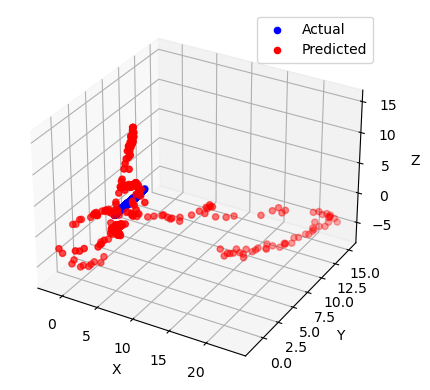

In [27]:
# Convert predictions back to original scale for plotting
from sklearn.metrics import mean_squared_error

Y_pred = gpr.predict(X_test)

Y_test_inv = scale.inverse_transform(Y_test)
Y_pred_inv = scale.inverse_transform(Y_pred)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

# 3D Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(Y_test_inv[:,0], Y_test_inv[:,1], Y_test_inv[:,2], color='b', label='Actual')
ax.scatter(Y_pred_inv[:,0], Y_pred_inv[:,1], Y_pred_inv[:,2], color='r',label='Predicted')
plt.legend()
plt.show()

GPR_delta model, trained on differences between adjacent points

In [33]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
import joblib

kernel = RBF()
gpr_delta = GaussianProcessRegressor(kernel=kernel)
gpr_delta.X_train_ = X_delta_train
gpr_delta.y_train_ = Y_delta_train
gpr_delta.n_features_in_ = 3
gpr_delta.fit(X_delta_train, Y_delta_train)

c:\Users\Esther\anaconda3\lib\site-packages\sklearn\gaussian_process\_gpr.py:610: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


GaussianProcessRegressor(kernel=RBF(length_scale=1))

GPR prediction, RMSE and plot

Mean Squared Error: 0.12942557522113565
Root Mean Squared Error: 0.3597576617962926


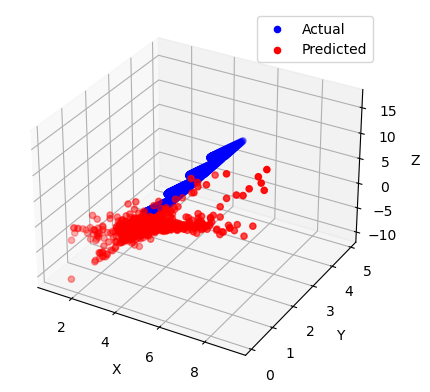

In [38]:
# Convert predictions back to original scale for plotting
from sklearn.metrics import mean_squared_error

Y_pred = gpr_delta.predict(X_delta_test)

Y_test_inv = scale.inverse_transform(Y_test)
Y_pred_inv = scale.inverse_transform(Y_pred)

# Evaluate the model
mse = mean_squared_error(Y_test, Y_pred)
rmse = np.sqrt(mse)

print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)

# 3D Plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.scatter(Y_test_inv[:,0], Y_test_inv[:,1], Y_test_inv[:,2], color='b', label='Actual')
ax.scatter(Y_pred_inv[:,0], Y_pred_inv[:,1], Y_pred_inv[:,2], color='r',label='Predicted')
plt.legend()
plt.show()

In [22]:
gpr.score(X_train, Y_train)
# joblib.dump(gpr, 'gaussian_process_model.pkl') # OSError: [Errno 28] No space left on device

0.9999999838022159

GPR1: Given 1 point, predict the next.

In [ ]:
def predict_next_point(currentPoint):
    newPoint = gpr.predict(currentPoint)
    return newPoint
